In [1]:
import numpy as np
import pandas as pd
import torch
import timeit
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from idlmam import *

In [3]:
# Bug: train_simple_network allows to pass None as parameter for score_funcs in idlmam.py loc 94. If we pass None as param run_epoch would fail
# Bugfix: add check for score_funcs
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())
        if score_funcs is not None:
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                #add to predictions so far
                y_true.extend(labels.tolist())
                y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


In [4]:
# Bug: train_simple_network allows to pass None as parameter for score_funcs in idlmam.py loc 94. If we pass None as param run_epoch would fail
# Bugfix: add check for score_funcs
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=20, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [5]:
class Simple1DRegressionDataset(Dataset):

    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

In [6]:
from sklearn.preprocessing import StandardScaler

#Crate a 1-dimensional input
X = np.linspace(0, 20, num=200)
#create an output
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
scaler = StandardScaler()

y_s = scaler.fit_transform(y.reshape(-1,1))

In [7]:
training_loader = DataLoader(Simple1DRegressionDataset(X, y_s), shuffle=True)

In [8]:
in_features = 1
out_features = 1
model = nn.Sequential(
    nn.Linear(in_features,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, out_features),#output layer
)

device = torch.device("cuda")
loss_func = nn.MSELoss()
results = train_simple_network(model, loss_func, training_loader, epochs=20, device=device, checkpoint_file='model.pt')
#results.head()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
with torch.no_grad():
    Y_pred = scaler.inverse_transform(model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy())

<AxesSubplot: >

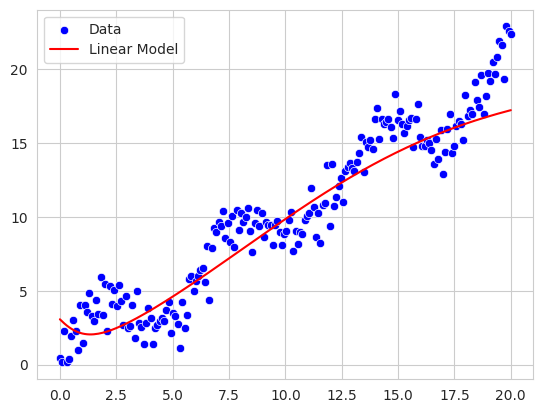

In [10]:
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') #What our model learned

It helps because our linear model gets smoother :)

### The area under the curve (AUC) metric does not follow the standard pattern in scikit-learn, as it requires y_pred to be a vector of shape (N) instead a matrix of shape (N,2). Write a wrapper function for AUC that makes it compatible with our train_simple_network function.

In [11]:
from sklearn import metrics

def auc(X, y):
    return metrics.auc(X, y.flatten())

In [12]:
auc(X, y_s)

-0.022062004110987132

### Write a new function resume_simple_network that loads a checkpoint_file from disk, restores both the optimizer and model states, and continues training to a specified total number of epochs. So if the model is saved after 20 epochs, and you specify 30 epochs, it should perform only 10 more epochs of training.

In [13]:
def resume_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                          epochs=30, device="cpu", checkpoint_file=None):
    checkpoint = torch.load(checkpoint_file)
    epoch = checkpoint['epoch']
    results = checkpoint['results']

    if epochs - epoch - 1 > 0:
        # reuse already known code
        #SGD is Stochastic Gradient Decent.
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        total_train_time = 0 #How long have we spent in the training loop?

        #Place the model on the correct compute resource (CPU or GPU)
        model.to(device)
        for epoch in tqdm(range(epoch+1, epochs), desc="Epoch"):
            model = model.train()#Put our model in training mode

            total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

            results["total time"].append( total_train_time )
            results["epoch"].append( epoch )

            if test_loader is not None:
                model = model.eval()
                with torch.no_grad():
                    run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    return pd.DataFrame.from_dict(results)


In [14]:
in_features = 1
out_features = 1
model = nn.Sequential(
    nn.Linear(in_features,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, out_features),#output layer
)

device = torch.device("cuda")
loss_func = nn.MSELoss()
results = resume_simple_network(model, loss_func, training_loader, epochs=30, device=device, checkpoint_file='model.pt')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

prove that our results have increased from 20 to 30 entries

In [15]:
results.tail()

,epoch,total time,train loss
25,25,1.400074,0.105808
26,26,1.692829,0.105412
27,27,1.952637,0.104942
28,28,2.203547,0.104561
29,29,2.441419,0.103799


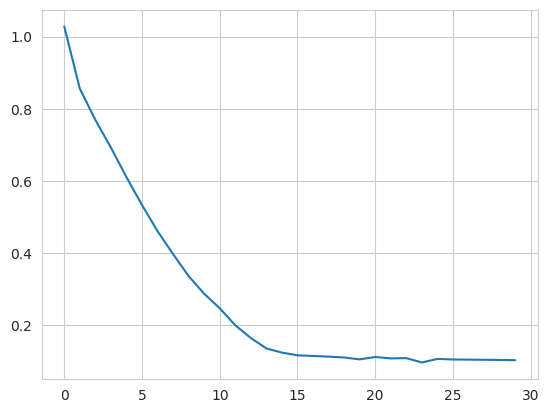

In [16]:
plt.plot(results['train loss'])

### When performing experiments, we may want to go back and try versions of our model from different epochs, especially if we are trying to determine when some weird behavior started to occur. Modify the train_simple_network function to take a new argument checkpoint_every_x that saves a version of the model every x epochs with different filenames. That way, you can go back and load a specific version without filling your hard drive with a model for every epoch.

In [17]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=20, device="cpu", checkpoint_file=None, checkpoint_every_x=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

        if checkpoint_file is not None and checkpoint_every_x is not None:
            if epoch % checkpoint_every_x == 0:
                checkpoint_file_name = checkpoint_file.split('.')[0]+"_epoch_"+str(epoch)+"."+checkpoint_file.split('.')[1]
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'results' : results
                    }, checkpoint_file_name)

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [18]:
in_features = 1
out_features = 1
model = nn.Sequential(
    nn.Linear(in_features,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, out_features),#output layer
)

device = torch.device("cuda")
loss_func = nn.MSELoss()
_ = train_simple_network(model, loss_func, training_loader, epochs=30, device=device, checkpoint_file='model.pt', checkpoint_every_x=10)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

### The input range of data can have a large impact on a neural network. This applies to inputs and outputs, as for regression problems. Try applying scikit-learn’s StandardScaler to the targets y of the toy regression problem at the start of this chapter, and train a new neural network on it. Does changing the scale of the outputs help or hurt the model’s predictions?

### The deep part of deep learning refers to the number of layers in a neural network. Try adding more layers (up to 20) to the models we used for the make_moons classification problem. How do more layers impact performance?

In [19]:
# Bugfix to work with cuda need to add defivce
def visualize2DSoftmax(X, y, model, title=None, device="cpu"):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32).to(device))
        y_hat = F.softmax(logits.cpu(), dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

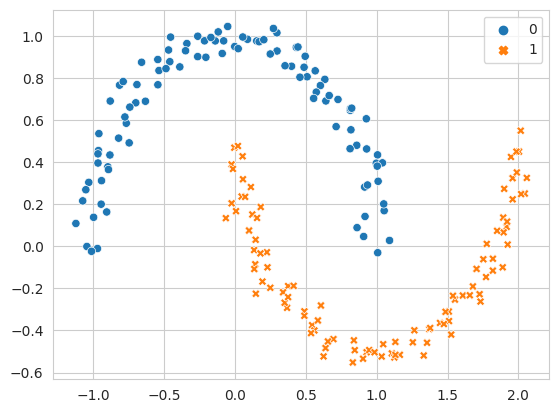

In [20]:
# lets create a make_moons networks with multiple layers
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [21]:
# first make_moons network
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 50),
    nn.Tanh(),
    nn.Linear(50, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

device = torch.device("cuda")
loss_func = nn.CrossEntropyLoss()
train = train_simple_network(model, loss_func, training_loader, epochs=250, device=device)

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

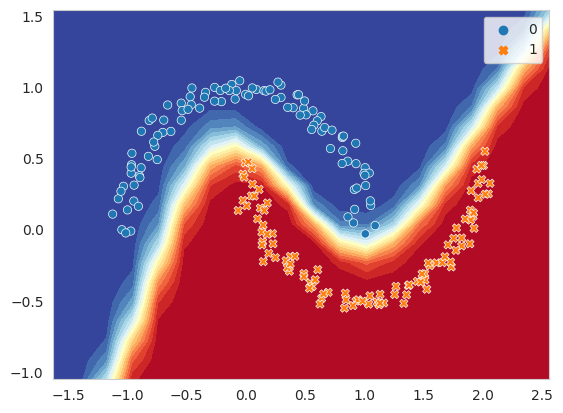

In [22]:
visualize2DSoftmax(X, y, model, device=device)

By adding more layers your model gets better :)

### Try changing the number of neurons used in the hidden layers of the make_moons classification problem. How does it impact performance?

In [23]:
# first make_moons network
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

model = nn.Sequential(
    nn.Linear(in_features, 150),
    nn.Tanh(),
    nn.Linear(150, 150),
    nn.Tanh(),
    nn.Linear(150, out_features)
)

device = torch.device("cuda")
loss_func = nn.CrossEntropyLoss()
train = train_simple_network(model, loss_func, training_loader, epochs=250, device=device)

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

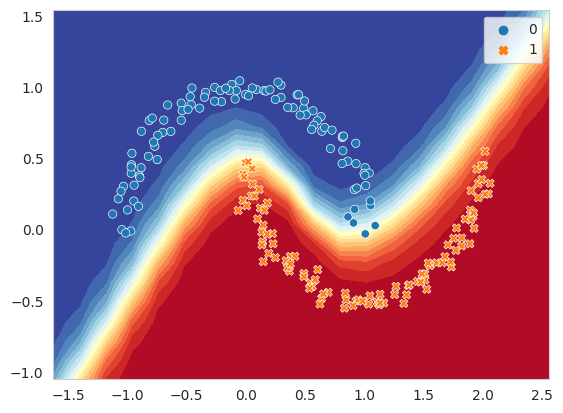

In [24]:
visualize2DSoftmax(X, y, model, device=device)

Increasing number of neurons seems to have the same effect as adding more linear layers in our example. It was even faster to use less layers with more neurons.
If we had to resolve a more challenging task with different type of layers it wouldn't behave the same way.

### Use scikit-learn to load the breast cancer Wisconsin dataset (https://scikit-learn.org/ stable/modules/generated/sklearn.datasets.load_breast_cancer.html), convert it into a TensorDataset, and then split it into 80% for training and 20% for testing. Try to build your own classification neural network for this data.

In [25]:
# load scikit stuff
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

from sklearn.datasets import load_breast_cancer
breast_data = load_breast_cancer()

score_funcs={'Acc':accuracy_score, 'F1': f1_score, 'Cohen': cohen_kappa_score}

X =  pd.DataFrame(data=breast_data.data, columns=[breast_data.feature_names])
y = pd.DataFrame(data=breast_data.target, columns=['target'])

# necessary have tried without that but network doesn't perform
scaler = StandardScaler()
X_s = scaler.fit_transform(X.values, y.values)

tds = TensorDataset(torch.tensor(X_s, dtype=torch.float32).to(device), torch.tensor(y.values.flatten(), dtype=torch.long).to(device))

# get number of entries for training and testing
num_of_train_rows = int(X.shape[0]*0.8)+((X.shape[0]*0.8) % 5 > 0) # get sure to round up
num_of_test_rows = int(X.shape[0]*0.2)

# split dataset
train, test = torch.utils.data.random_split(tds, lengths=[num_of_train_rows, num_of_test_rows], generator=torch.Generator().manual_seed(42))

training_loader = DataLoader(train, shuffle=True)
testing_loader = DataLoader(test, shuffle=True)

In [26]:
print("number of features: "+str(X.shape[1]))
print("number of classes: "+str(int(y.target.nunique())))

number of features: 30
number of classes: 2


In [27]:
# try to build your own classifcation network
# first make_moons network
in_features = X.shape[1]
out_features = int(y.target.nunique())
model = nn.Linear(in_features, out_features)

model = nn.Sequential(
    nn.Linear(in_features, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, out_features)
)

device = torch.device("cuda")
loss_func = nn.CrossEntropyLoss()
results = train_simple_network(model, loss_func, training_loader, testing_loader, score_funcs, epochs=50, device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

Training:   0%|          | 0/456 [00:00<?, ?it/s]

Testing:   0%|          | 0/113 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Cohen'>

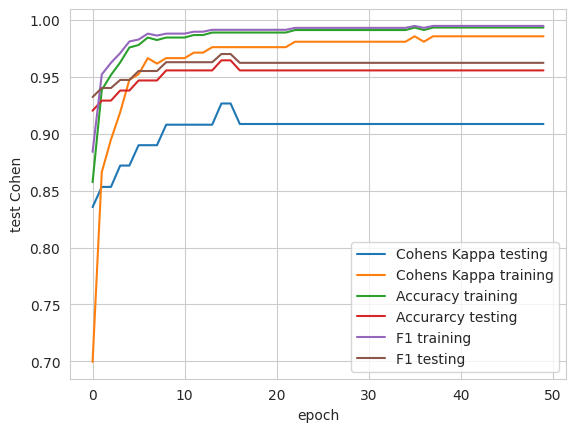

In [28]:
sns.lineplot(x='epoch', y='test Cohen', data=results, label='Cohens Kappa testing')
sns.lineplot(x='epoch', y='train Cohen', data=results, label='Cohens Kappa training')
sns.lineplot(x='epoch', y='train Acc', data=results, label='Accuracy training')
sns.lineplot(x='epoch', y='test Acc', data=results, label='Accurarcy testing')
sns.lineplot(x='epoch', y='train F1', data=results, label='F1 training')
sns.lineplot(x='epoch', y='test F1', data=results, label='F1 testing')

### We saw results on the make_moons dataset with a batch size of B = {1, 32, N}. Write a loop to train a new model on that same dataset for every power-of-two batch size less than N (i.e., B = {2, 4, 8, 16, 32, 64, …}, and plot the results. Do you notice any trends in terms of accuracy and/or training time?

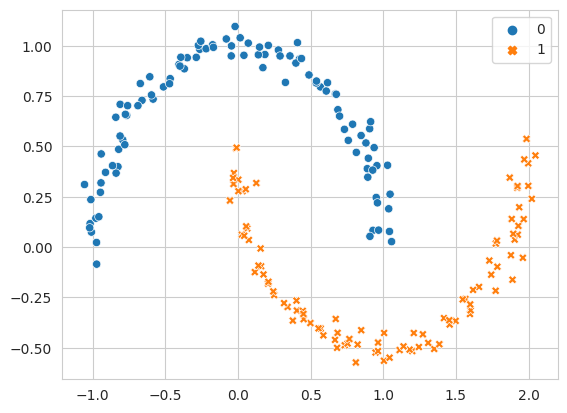

In [29]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

# first make_moons network
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 50),
    nn.Tanh(),
    nn.Linear(50, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

device = torch.device("cuda")

In [30]:
score_funcs={'Acc':accuracy_score, 'F1': f1_score, 'Cohen': cohen_kappa_score}
loss_func = nn.CrossEntropyLoss()

N = 8

trainings = pd.DataFrame()
for i in range(N):
    training_loader = DataLoader(classification_dataset, batch_size=2**i)

    train = train_simple_network(model, loss_func, training_loader, score_funcs=score_funcs, epochs=50, device=device)
    train['batch_size'] = 2**i
    trainings = pd.concat([trainings, train.tail(1)], ignore_index=True)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

<AxesSubplot: xlabel='total time', ylabel='batch_size'>

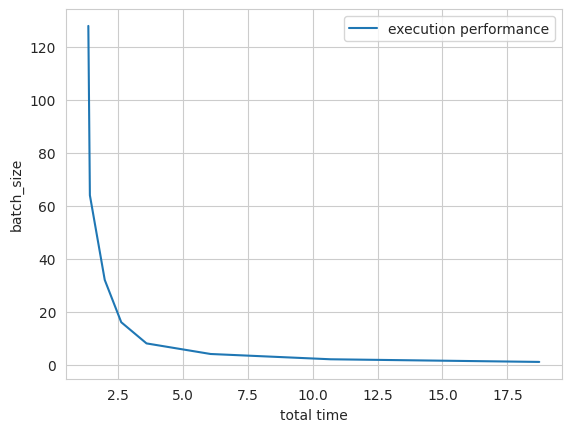

In [31]:
sns.lineplot(x='total time', y='batch_size', data=trainings, label='execution performance')

<AxesSubplot: xlabel='train Acc', ylabel='batch_size'>

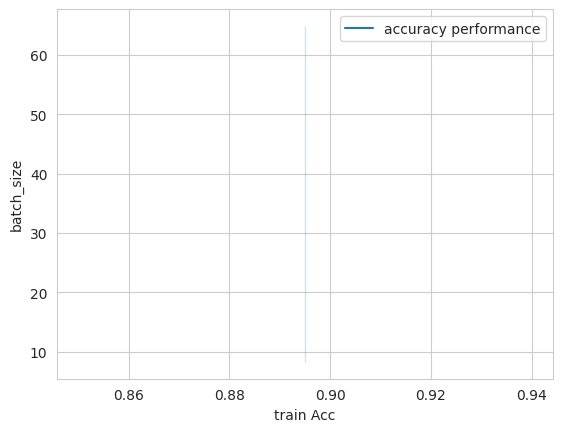

In [32]:
sns.lineplot(x='train Acc', y='batch_size', data=trainings, label='accuracy performance')

It seems like higher batch size has a positive impact on time and accuracy during our training >> it gets even better and faster